In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================
class Config:
    MODEL_NAME = "distilbert-base-uncased"
    DATASET_NAME = "glue"
    DATASET_CONFIG = "mnli"

    NUM_LABELS = 3
    MAX_LENGTH = 128

    TRAIN_SAMPLES = 10_000
    VAL_SAMPLES = 1_000

    BATCH_TRAIN = 32
    BATCH_EVAL = 64
    EPOCHS = 3
    LR = 5e-5
    WEIGHT_DECAY = 0.01
    WARMUP_STEPS = 200
    SEED = 42

    OUTPUT_DIR = "./results_mnli"
    SAVE_DIR = "./fine-tuned-distilbert-mnli"

# =============================================================================
# INSTALL & IMPORTS
# =============================================================================
!pip install -q transformers datasets evaluate accelerate scikit-learn matplotlib seaborn

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import evaluate
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# =============================================================================
# UTILITIES
# =============================================================================
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def print_device_info():
    print(f"PyTorch: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")

# =============================================================================
# DATA LOADING
# =============================================================================
def load_data():
    dataset = load_dataset(Config.DATASET_NAME, Config.DATASET_CONFIG)

    train_data = dataset["train"].shuffle(seed=Config.SEED).select(
        range(Config.TRAIN_SAMPLES)
    )
    val_data = dataset["validation_matched"].shuffle(seed=Config.SEED).select(
        range(Config.VAL_SAMPLES)
    )

    return DatasetDict({
        "train": train_data,
        "validation": val_data
    })

# =============================================================================
# EXPLORATORY DATA ANALYSIS (EDA)
# =============================================================================
def run_eda(dataset):
    print("\n========== EDA: MNLI Dataset ==========")

    df = dataset["train"].to_pandas()
    label_map = {0: "Entailment", 1: "Neutral", 2: "Contradiction"}
    df["label_name"] = df["label"].map(label_map)

    # Label distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x="label_name", order=label_map.values())
    plt.title("Label Distribution (Train Set)")
    plt.tight_layout()
    plt.show()

    print("\nLabel Proportions:")
    print(df["label_name"].value_counts(normalize=True))

    # Length analysis
    df["premise_len"] = df["premise"].str.split().str.len()
    df["hypothesis_len"] = df["hypothesis"].str.split().str.len()

    print("\nText Length Statistics:")
    print(df[["premise_len", "hypothesis_len"]].describe())

# =============================================================================
# TOKENIZATION
# =============================================================================
def tokenize_dataset(dataset, tokenizer):
    def tokenize_fn(batch):
        return tokenizer(
            batch["premise"],
            batch["hypothesis"],
            truncation=True,
            padding="max_length",
            max_length=Config.MAX_LENGTH,
        )

    tokenized = dataset.map(tokenize_fn, batched=True)
    tokenized = tokenized.remove_columns(
        [c for c in tokenized["train"].column_names
         if c not in ["input_ids", "attention_mask", "label"]]
    )
    tokenized = tokenized.rename_column("label", "labels")
    tokenized.set_format("torch")

    return tokenized

# =============================================================================
# MODEL
# =============================================================================
def load_model():
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        Config.MODEL_NAME,
        num_labels=Config.NUM_LABELS,
    )
    return tokenizer, model

# =============================================================================
# METRICS
# =============================================================================
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

# =============================================================================
# TRAINING
# =============================================================================
def train_model(model, tokenized_data):
    args = TrainingArguments(
        output_dir=Config.OUTPUT_DIR,
        num_train_epochs=Config.EPOCHS,
        per_device_train_batch_size=Config.BATCH_TRAIN,
        per_device_eval_batch_size=Config.BATCH_EVAL,
        learning_rate=Config.LR,
        warmup_steps=Config.WARMUP_STEPS,
        weight_decay=Config.WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        fp16=torch.cuda.is_available(),
        logging_steps=50,
        report_to="none",
        seed=Config.SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["validation"],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    return trainer

# =============================================================================
# EVALUATION
# =============================================================================
def evaluate_model(trainer, tokenized_data):
    predictions = trainer.predict(tokenized_data["validation"])
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    labels = ["Entailment", "Neutral", "Contradiction"]

    print("\nClassification Report")
    print(classification_report(y_true, y_pred, target_names=labels, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix - MNLI")
    plt.tight_layout()
    plt.show()

# =============================================================================
# INFERENCE
# =============================================================================
def predict_nli(premise, hypothesis, model, tokenizer):
    inputs = tokenizer(
        premise, hypothesis,
        return_tensors="pt",
        truncation=True,
        padding=True
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=-1)
    label = torch.argmax(probs, dim=-1).item()

    return label, probs[0][label].item()

# =============================================================================
# MAIN PIPELINE
# =============================================================================
def main():
    set_seed(Config.SEED)
    print_device_info()

    dataset = load_data()
    run_eda(dataset)

    tokenizer, model = load_model()
    tokenized = tokenize_dataset(dataset, tokenizer)

    trainer = train_model(model, tokenized)
    evaluate_model(trainer, tokenized)

    model.save_pretrained(Config.SAVE_DIR)
    tokenizer.save_pretrained(Config.SAVE_DIR)
    print(f"\nModel saved to {Config.SAVE_DIR}")

    samples = [
        ("A woman plays violin.", "A person performs music."),
        ("A man reads in library.", "The man sleeps on couch."),
        ("Children play in park.", "The children have fun."),
    ]

    label_map = ["Entailment", "Neutral", "Contradiction"]

    for p, h in samples:
        label, conf = predict_nli(p, h, model, tokenizer)
        print(f"\nPremise: {p}")
        print(f"Hypothesis: {h}")
        print(f"Prediction: {label_map[label]} ({conf:.2%})")

PyTorch: 2.9.0+cu126
CUDA available: True

========== EDA: MNLI Dataset ==========


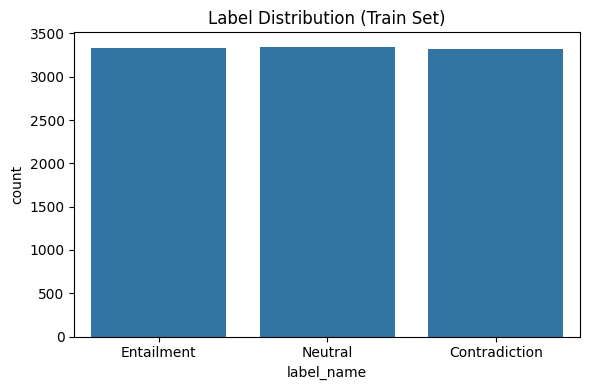


Label Proportions:
label_name
Neutral          0.3346
Entailment       0.3333
Contradiction    0.3321
Name: proportion, dtype: float64

Text Length Statistics:
       premise_len  hypothesis_len
count  10000.00000    10000.000000
mean      19.89940        9.978100
std       14.29827        4.291301
min        1.00000        1.000000
25%       10.00000        7.000000
50%       17.00000        9.000000
75%       26.00000       12.000000
max      281.00000       43.000000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.833200,0.800351,0.649000,0.648598
2,0.639100,0.755661,0.675000,0.675282
3,0.362800,0.853735,0.685000,0.685621



Classification Report
               precision    recall  f1-score   support

   Entailment     0.7400    0.6707    0.7036       331
      Neutral     0.6253    0.7226    0.6704       328
Contradiction     0.7040    0.6628    0.6828       341

     accuracy                         0.6850      1000
    macro avg     0.6898    0.6853    0.6856      1000
 weighted avg     0.6901    0.6850    0.6856      1000



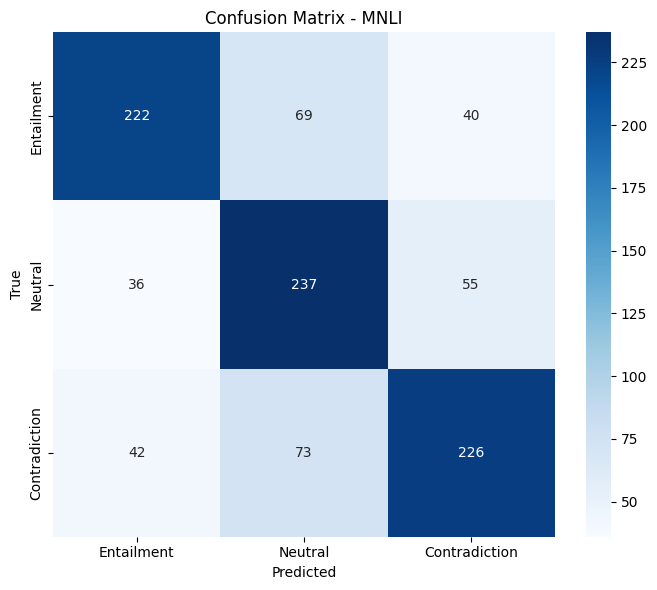


Model saved to ./fine-tuned-distilbert-mnli

Premise: A woman plays violin.
Hypothesis: A person performs music.
Prediction: Entailment (86.53%)

Premise: A man reads in library.
Hypothesis: The man sleeps on couch.
Prediction: Contradiction (77.18%)

Premise: Children play in park.
Hypothesis: The children have fun.
Prediction: Neutral (66.66%)


In [5]:
# =============================================================================
# RUN
# =============================================================================
main()